In [1]:
import numpy as np
import pandas as pd 
import csv
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score,recall_score,f1_score,classification_report
from sklearn.utils import class_weight
import pickle
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                        TensorBoard)

In [2]:
# some codes to ignore warnings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.experimental.do_not_convert(
    func=None
)
tf.autograph.set_verbosity(0)

In [3]:
#get input data
x=np.loadtxt('xvalues')

#the number of profiles
count=75446

#reshape the data
input_x=x.reshape(count,210)

#get label data
f = csv.reader(open('cape.csv','r'))
list_y=[float(row[1]) for row in f]


In [4]:
#the function of transforming CAPE into bin
#input: CAPE(float)
#return: index of bin(integer)

def set_bin(data):
    if data==0:
        return 0
    else:
        return np.argmin(abs(data-bins[1:]))+1

In [5]:
#create 10 bins
bins=np.logspace(np.log10(5),np.log10(2500),9)
bins=np.append(0,bins)

In [6]:
# transform all CAPEs into bins
y_new=list(map(set_bin,list_y))
input_y=np.array(y_new).reshape(-1,1)

<AxesSubplot:ylabel='Count'>

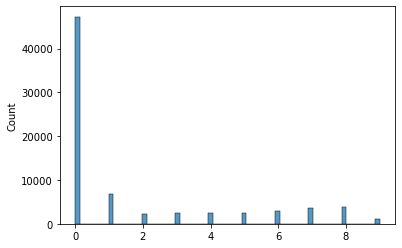

In [7]:
#plot the distribution of CAPEs
sns.histplot(y_new)

In [8]:
#train, test spliting
x_train_mu,x_test_mu,y_train_mu,y_test_mu=train_test_split(input_x,input_y,test_size=0.20,random_state=42)

In [9]:
#pre processing data
sc = StandardScaler()
sc.fit(x_train_mu)
x_train_mu= sc.transform(x_train_mu)
x_test_mu = sc.transform(x_test_mu)

In [10]:
#save the standardscaler which is used on Mass Data
pickle.dump(sc, open('scaler.pkl','wb'))

In [11]:
#reshape input data to satisfy the requirements of tensorflow
x_train_mu=x_train_mu.reshape(x_train_mu.shape[0],70,3,1)
x_test_mu=x_test_mu.reshape(x_test_mu.shape[0],70,3,1)

In [12]:
#function of one hot code input y
#input: y_train(2-d np.array), y_test(2-d np.array), num_classes(integer)
#return: y_train (2-d np.array), y_train (2-d np.array)

def one_hot_code(y_train,y_test,num_classes):
    y_train= tf.keras.utils.to_categorical(y_train, num_classes)
    y_test= tf.keras.utils.to_categorical(y_test, num_classes)
    return y_train,y_test

In [13]:
#one hot code
y_train_mu,y_test_mu=one_hot_code(y_train_mu,y_test_mu,10)

In [14]:
# creating callbacks of earlystopping and reducing learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)

In [15]:
# the structure of the model 
def simple_lenet():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu",input_shape=[70, 3, 1]))
    model.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
    model.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(120,activation="relu"))
    model.add(layers.Dense(84,activation="relu"))
    model.add(layers.Dense(10,activation="softmax"))
    return model

In [16]:
#the structure of the model
def simple_lenet_nopooling():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",activation="relu",input_shape=[70, 3, 1]))
#     model.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding="same",activation="relu"))
#     model.add(layers.MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(120,activation="relu"))
    model.add(layers.Dense(84,activation="relu"))
    model.add(layers.Dense(10,activation="softmax"))
    return model

In [33]:
# the function to plot and save loss result
# input: history(tf.history) title (string)
# return:****

def plot_results(history,title):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    
    epochs = range(1,len(loss_values)+1)
    plt.figure()
    plt.plot(epochs,loss_values,'r',label='Training_loss')
    plt.plot(epochs,val_loss_values,'b',label = 'validation_loss')
    t='Loss'+'('+title+')'
    plt.title(t)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('pic/'+t+'.png')
    plt.show()
    

In [18]:
# the function of fitting the model
# input: model(keras.model), num_epoch(integer), callback(boolean)
# return: history(keras.callbacks.History)

def run_model(model,num_epoch,callback):
    lenet=model
    opt=keras.optimizers.Adam(learning_rate=0.001)
    lenet.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=opt,
              metrics=['accuracy'])
    if callback==True:
        history= lenet.fit(x_train_mu, y_train_mu, epochs=num_epoch, verbose=1,batch_size=32,
                    validation_data=(x_test_mu, y_test_mu),callbacks=[reduce_lr,early_stopping])
    else:
        history= lenet.fit(x_train_mu, y_train_mu, epochs=num_epoch, verbose=1,batch_size=32,
                    validation_data=(x_test_mu, y_test_mu))
    return history,lenet
    

In [37]:
#one function of prediction which will return the bin number of true CAPE and predicting CAPE
#input: x_test(2-d np.array),y_test(2-d np.array) model(keras.model)
#return y_pred(1-d np.array), y_true (1-d np.array)

def prediction(x_test,y_test,model):
    y_pred=np.argmax(model.predict(x_test), axis=-1)
    y_true=np.argmax(y_test,axis=1)
    return y_pred,y_true

In [34]:
#one function to plot and save heatmap of predictions
#input: y_pred(1-d np.array), y_true (1-d np.array), file_name(string)
#return: ***

def plot_heatmap(y_true,y_pred,file_name):
    plt.figure()
    clf=classification_report(y_true, y_pred,output_dict=True)
    fig=sns.heatmap(pd.DataFrame(clf).iloc[:-1, :].T, annot=True,cmap="YlGnBu")
    heatmap = fig.get_figure()
    heatmap.savefig('pic/'+file_name, dpi = 400)
    

In [35]:
# a function to save model and plot heatmap and loss
#input: y_pred(1-d np.array), y_true (1-d np.array), history(keras.history), model(keras.model), title(string)
#return:***

def save_and_plot(y_pred,y_true,history,model,title):
    model.save('model/'+title+'.h5')
    plot_heatmap(y_true,y_pred,title)
    plot_results(history,title)

In [21]:
# fit lenet with 50 epochs
history_50epochs_false,model_50epochs_false=run_model(simple_lenet(),50,False)

2021-09-09 10:46:45.987386: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-09 10:46:45.991155: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


Epoch 1/50
1887/1887 [==============================] - 17s 9ms/step - loss: 0.9770 - accuracy: 0.6795 - val_loss: 0.7341 - val_accuracy: 0.7158
Epoch 2/50
1887/1887 [==============================] - 15s 8ms/step - loss: 0.6407 - accuracy: 0.7495 - val_loss: 0.5694 - val_accuracy: 0.7778
Epoch 3/50
1887/1887 [==============================] - 15s 8ms/step - loss: 0.5595 - accuracy: 0.7784 - val_loss: 0.5460 - val_accuracy: 0.7793
Epoch 4/50
1887/1887 [==============================] - 15s 8ms/step - loss: 0.5369 - accuracy: 0.7819 - val_loss: 0.5291 - val_accuracy: 0.7863
Epoch 5/50
1887/1887 [==============================] - 15s 8ms/step - loss: 0.4885 - accuracy: 0.8000 - val_loss: 0.5088 - val_accuracy: 0.7951
Epoch 6/50
1887/1887 [==============================] - 16s 8ms/step - loss: 0.4675 - accuracy: 0.8087 - val_loss: 0.5131 - val_accuracy: 0.7935
Epoch 7/50
1887/1887 [==============================] - 16s 9ms/step - loss: 0.4499 - accuracy: 0.8156 - val_loss: 0.4784 - val_ac

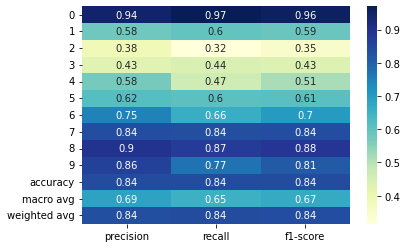

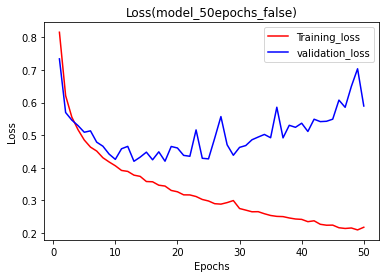

In [38]:
#make predictions and save and plot all informations
y_pred,y_true=prediction(x_test_mu,y_test_mu,model_50epochs_false)
save_and_plot(y_pred,y_true,history_50epochs_false,model_50epochs_false,"model_50epochs_false")


In [39]:
# fit lenet with 100 epochs
history_100epochs_false,model_100epochs_false=run_model(simple_lenet(),100,False)

Epoch 1/100
1887/1887 [==============================] - 16s 8ms/step - loss: 0.9276 - accuracy: 0.6926 - val_loss: 0.6804 - val_accuracy: 0.7329
Epoch 2/100
1887/1887 [==============================] - 15s 8ms/step - loss: 0.6295 - accuracy: 0.7555 - val_loss: 0.5701 - val_accuracy: 0.7760
Epoch 3/100
1887/1887 [==============================] - 15s 8ms/step - loss: 0.5588 - accuracy: 0.7758 - val_loss: 0.5462 - val_accuracy: 0.7810
Epoch 4/100
1887/1887 [==============================] - 16s 8ms/step - loss: 0.5191 - accuracy: 0.7894 - val_loss: 0.5203 - val_accuracy: 0.7826
Epoch 5/100
1887/1887 [==============================] - 15s 8ms/step - loss: 0.4957 - accuracy: 0.8002 - val_loss: 0.5248 - val_accuracy: 0.7824
Epoch 6/100
1887/1887 [==============================] - 15s 8ms/step - loss: 0.4613 - accuracy: 0.8108 - val_loss: 0.4532 - val_accuracy: 0.8133
Epoch 7/100
1887/1887 [==============================] - 15s 8ms/step - loss: 0.4451 - accuracy: 0.8179 - val_loss: 0.5298 -

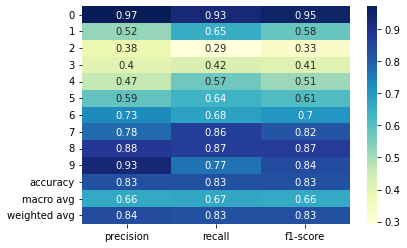

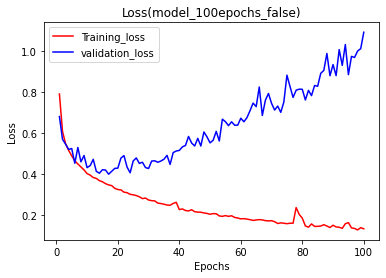

In [40]:
#make predictions and save and plot all informations
y_pred,y_true=prediction(x_test_mu,y_test_mu,model_100epochs_false)
save_and_plot(y_pred,y_true,history_100epochs_false,model_100epochs_false,"model_100epochs_false")

In [42]:
#fit lenet with 50 epochs and change learning rate, stop early
history_50epochs_true,model_50epochs_true=run_model(simple_lenet(),50,True)

Epoch 1/50
1887/1887 [==============================] - 15s 8ms/step - loss: 0.9409 - accuracy: 0.6857 - val_loss: 0.6442 - val_accuracy: 0.7487
Epoch 2/50
1887/1887 [==============================] - 16s 8ms/step - loss: 0.6449 - accuracy: 0.7516 - val_loss: 0.6089 - val_accuracy: 0.7636
Epoch 3/50
1887/1887 [==============================] - 15s 8ms/step - loss: 0.5530 - accuracy: 0.7797 - val_loss: 0.6546 - val_accuracy: 0.7429
Epoch 4/50
1887/1887 [==============================] - 14s 7ms/step - loss: 0.5233 - accuracy: 0.7874 - val_loss: 0.5264 - val_accuracy: 0.7788
Epoch 5/50
1887/1887 [==============================] - 14s 8ms/step - loss: 0.4828 - accuracy: 0.8016 - val_loss: 0.4870 - val_accuracy: 0.8011
Epoch 6/50
1887/1887 [==============================] - 14s 8ms/step - loss: 0.4626 - accuracy: 0.8085 - val_loss: 0.4725 - val_accuracy: 0.8041
Epoch 7/50
1887/1887 [==============================] - 14s 8ms/step - loss: 0.4469 - accuracy: 0.8182 - val_loss: 0.4928 - val_ac

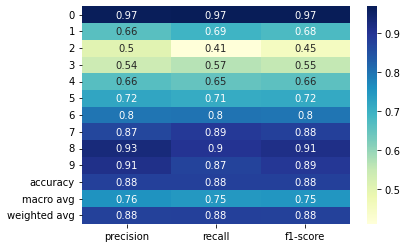

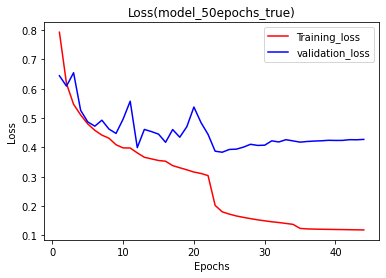

In [44]:
#make predictions and save and plot all informations
y_pred,y_true=prediction(x_test_mu,y_test_mu,model_50epochs_true)
save_and_plot(y_pred,y_true,history_50epochs_true,model_50epochs_true,"model_50epochs_true")

In [46]:
#fit no max-pooling model with 50 epochs and change learning rate, stop early
history_50epochs_true_nopool,model_50epochs_true_nopool=run_model(simple_lenet_nopooling(),50,True)

Epoch 1/50
1887/1887 [==============================] - 52s 28ms/step - loss: 0.9402 - accuracy: 0.6840 - val_loss: 0.6989 - val_accuracy: 0.7240
Epoch 2/50
1887/1887 [==============================] - 54s 29ms/step - loss: 0.6197 - accuracy: 0.7604 - val_loss: 0.5730 - val_accuracy: 0.7680
Epoch 3/50
1887/1887 [==============================] - 52s 27ms/step - loss: 0.5366 - accuracy: 0.7847 - val_loss: 0.5667 - val_accuracy: 0.7720
Epoch 4/50
1887/1887 [==============================] - 53s 28ms/step - loss: 0.4958 - accuracy: 0.8024 - val_loss: 0.5445 - val_accuracy: 0.7832
Epoch 5/50
1887/1887 [==============================] - 42s 22ms/step - loss: 0.4474 - accuracy: 0.8172 - val_loss: 0.4800 - val_accuracy: 0.8087
Epoch 6/50
1887/1887 [==============================] - 34s 18ms/step - loss: 0.4174 - accuracy: 0.8278 - val_loss: 0.4335 - val_accuracy: 0.8172
Epoch 7/50
1887/1887 [==============================] - 31s 17ms/step - loss: 0.3912 - accuracy: 0.8376 - val_loss: 0.4016 -

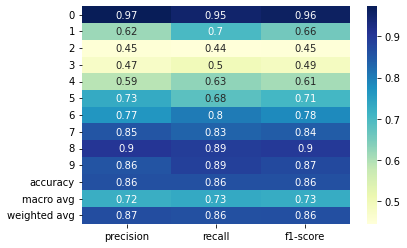

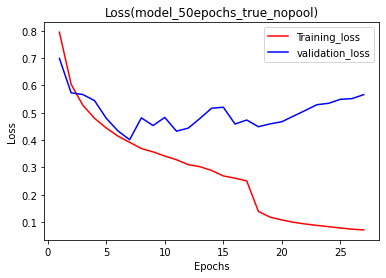

In [47]:
#make predictions and save and plot all informations
y_pred,y_true=prediction(x_test_mu,y_test_mu,model_50epochs_true_nopool)
save_and_plot(y_pred,y_true,history_50epochs_true_nopool,model_50epochs_true_nopool,"model_50epochs_true_nopool")

In [70]:
#load mass data
y_mass=np.loadtxt("MASScape.txt")
x_mass=np.loadtxt("x_mass.txt")

In [71]:
#set bins for mass data
y_bin=list(map(set_bin,y_mass))
y_new=np.array(y_bin).reshape(-1,1)

In [72]:
#pre-process mass data
input_xmass=sc.transform(x_mass)
input_xmass=input_xmass.reshape(input_xmass.shape[0],70,3,1)
input_ymass= tf.keras.utils.to_categorical(y_new, 10)

/Users/renyuzhe/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/renyuzhe/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/renyuzhe/miniforge3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

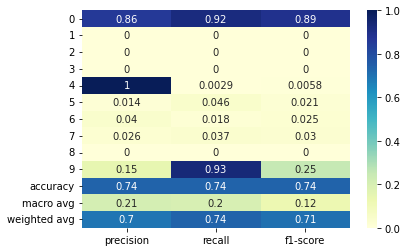

In [75]:
y_pred,y_true=prediction(input_xmass,input_ymass,model_50epochs_true)
plot_heatmap(y_true,y_pred,"MASS")